In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA  # Import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
def convert_to_numeric(value_str):
    if pd.isna(value_str):
        return None
    value_str = str(value_str)
    if value_str == '':
        return 0
    value_str = value_str.replace(',', '')  # Remove commas
    value_str = value_str.replace(' Lac+', '00000')  # Convert 'Lac+' to scientific notation
    value_str = value_str.replace(' Crore+', '0000000')  # Convert 'Crore+' to scientific notation
    value_str = value_str.replace(' Thou+', '000')  # Convert 'Thou+' to scientific notation
    value_str = value_str.replace(' Hund+', '00')  # Convert 'Hund+' to scientific notation
    # Extract numeric value using regular expression
    numeric_value = re.search(r'(\d+(\.\d+)?)', value_str)
    if numeric_value:
        return float(numeric_value.group(1))
    else:
        return None

def conf_mat(train_data,preds):
    conf_matrix = confusion_matrix(train_data['Education'], preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def feature_imp(rf_classifier,X_train,y_train):
    rf_classifier.fit(X_train, y_train)
    feature_importances = rf_classifier.feature_importances_

   
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances, tick_label=X_train.columns)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=0)
    plt.show()

def scatter(X_train_pca,y_train_encoded):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap='viridis', s=50, alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Scatter Plot of PCA Components')
    plt.colorbar(label='Target Label')
    plt.show()

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Combine train and test data for one-hot encoding
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Convert 'Total Assets' and 'Liabilities' columns to numeric
combined_data['Total Assets'] = combined_data['Total Assets'].apply(convert_to_numeric)
combined_data['Liabilities'] = combined_data['Liabilities'].apply(convert_to_numeric)



# Split the combined data back into train and test
train_data_encoded = combined_data.iloc[:len(train_data)]
test_data_encoded = combined_data.iloc[len(train_data):]

# Split the data into features and target variable
X_train = train_data_encoded.drop(columns=['Constituency', 'ID', 'Education', 'Candidate','Party', 'state'])
y_train = train_data_encoded['Education']
X_test = test_data_encoded.drop(columns=['Constituency', 'ID', 'Candidate', 'Education','Party', 'state'])

combined_data = pd.get_dummies(combined_data, columns=['Party', 'state'])

# Split the combined data back into train and test
train_data_encoded = combined_data.iloc[:len(train_data)]
test_data_encoded = combined_data.iloc[len(train_data):]

X_train_pca = train_data_encoded.drop(columns=['Constituency', 'ID', 'Education', 'Candidate'])

X_test_pca = test_data_encoded.drop(columns=['Constituency', 'ID', 'Candidate', 'Education'])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Choose the number of components as desired
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)
label_encoder = LabelEncoder()
print(X_train_pca.shape)
# Encode the string labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)

# Scatter plot with encoded labels

# Now X_train_pca and X_test_pca are the transformed feature matrices after PCA

# Print the explained variance for each component
explained_variance = pca.explained_variance_ratio_
for i, var in enumerate(explained_variance):
    print(f"Explained variance of component {i + 1}: {var:.2f}")

# Define parameters for Random Forest Classifier
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced'],
    'random_state': [0],
    'oob_score': [True, False]
}

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier()
#feature_imp(rf_classifier,X_train)
grid = GridSearchCV(estimator=rf_classifier, param_grid=parameters, cv=5, scoring='accuracy')
grid.fit(X_train_pca, y_train)
opt_params = grid.best_params_
opt_score = grid.best_score_



opt_model = grid.best_estimator_
preds = opt_model.predict(X_train_pca)

accuracy = accuracy_score(y_train, preds)



# Make predictions on the test dataset
y_test_pred = opt_model.predict(X_test_pca)

# Save the predictions in the required format
submission_df = pd.DataFrame({'ID': test_data['ID'], 'Education': y_test_pred})
submission_df.to_csv('submission.csv', index=False)

(2059, 2)
Explained variance of component 1: 0.91
Explained variance of component 2: 0.09


c:\Users\arnav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arnav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\arnav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only availab

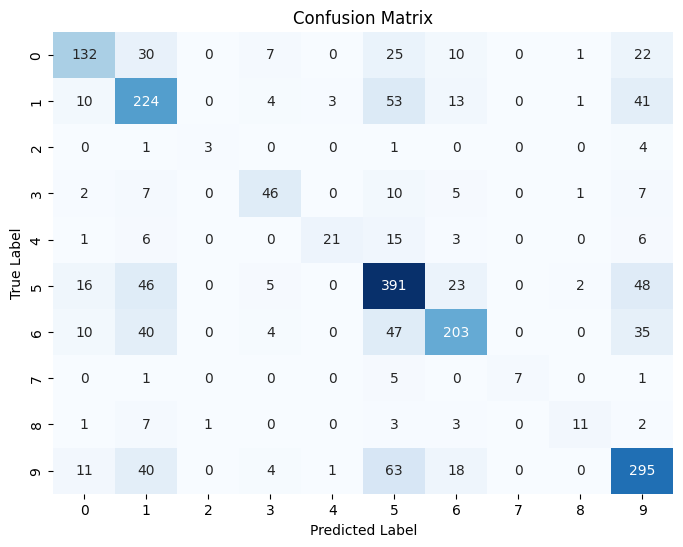

In [4]:
conf_mat(train_data,preds)


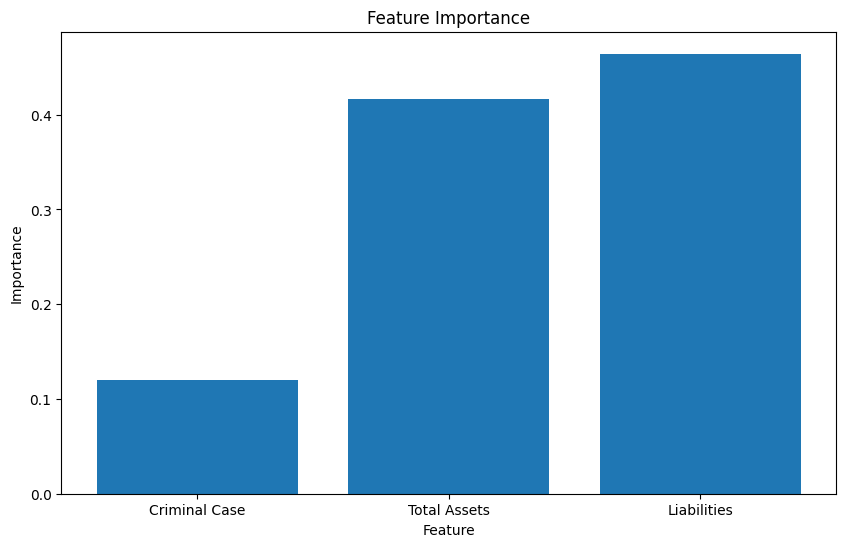

In [5]:
feature_imp(rf_classifier,X_train,y_train)


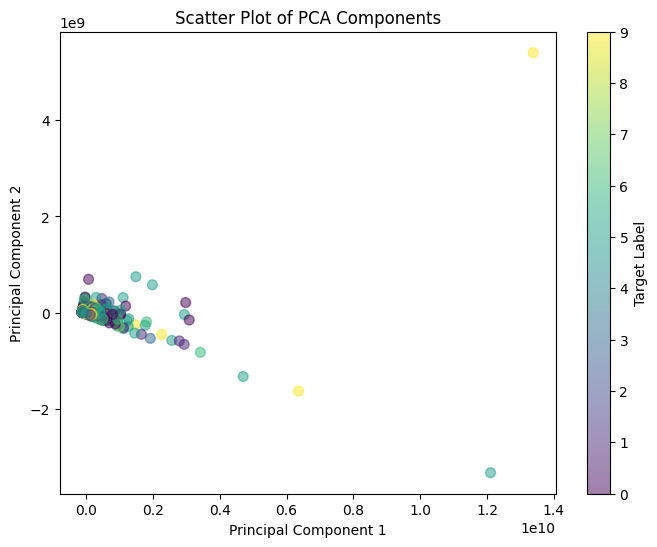

In [6]:

scatter(X_train_pca,y_train_encoded)